# Predicting Current Ability for players in Football Manager 2022

Current Ability (CA) measures the player`s ability for a specific position. It has  a direct relation with the players attributes (at least the ones that are important for said position). 

This measure is not directly observable in the game. It can be obtained through a series of formulas, but this represents a problem when it comes to scouted players, as scouts can fail depending on their ability and they are a limited resource, that is, even if the report was a 100% accurate, calculating the CA for every player would be very slow. For this reason, I will try to specify a regression model that predicts CA.

The data used for this purpose comes from each player performance, which is easier to obtain and is usually more abundant.

## Importing the packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
from sklearn.model_selection import cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sma

In [3]:
plt.style.use("ggplot")

## Loading the data and analyzing the dataset

The data presented here has been previously cleaned and prepared for the analysis. It does not contain goalkeepers, as the model does not fit well in this case. Moreover, players in the database with less than 10 matches have been removed.

In [4]:
df = pd.read_excel("variables.xlsx", header = 0)
df.drop("Unnamed: 0",axis = 1, inplace = True)
df["l_value"] = np.log(df["Value"])
df["l_value2"] = df["l_value"]*df["l_value"]
df.head()

,Name,Apps,Mins,Mins/Gm,Height,Weight,Age,Av Rat,Gls,Gls/90,...,Tck R,CA,Saves,Saves/xSv%,Gls/xG,Dist/Mins,Transfer Value,Value,l_value,l_value2
0,Josip Mijatović,12,809,67.416667,173,68,20,7.14,1,0.11,...,0.88,84,0,0.0,5.555556,0.126823,€3K - €9K,6000.0,8.699515,75.681557
1,Duje Ninčević,15,1161,77.400000,172,69,25,6.84,0,0.00,...,0.76,79,0,0.0,0.000000,0.129457,€0 - €2.5K,1250.0,7.130899,50.849718
2,Marin Karabatić,15,1350,90.000000,170,62,22,6.90,0,0.00,...,0.77,87,0,0.0,0.000000,0.128000,€0 - €12K,6000.0,8.699515,75.681557
3,Vicko Ševelj,20,1738,86.900000,192,86,22,7.15,1,0.05,...,0.88,95,0,0.0,2.380952,0.058631,€100K - €1M,550000.0,13.217674,174.706894
4,Fran Vujnović,15,1384,92.266667,190,77,19,7.23,4,0.26,...,0.93,83,0,0.0,0.000000,0.016040,€14K - €150K,82000.0,11.314475,128.017334


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              1122 non-null   object 
 1   Apps              1122 non-null   int64  
 2   Mins              1122 non-null   int64  
 3   Mins/Gm           1122 non-null   float64
 4   Height            1122 non-null   int64  
 5   Weight            1122 non-null   int64  
 6   Age               1122 non-null   int64  
 7   Av Rat            1122 non-null   float64
 8   Gls               1122 non-null   int64  
 9   Gls/90            1122 non-null   float64
 10  Shot %            1122 non-null   float64
 11  Pen/R             1122 non-null   float64
 12  xG                1122 non-null   float64
 13  Ch C/90           1122 non-null   float64
 14  Asts/90           1122 non-null   float64
 15  K Ps/90           1122 non-null   float64
 16  Pas %             1122 non-null   float64


As it can be seen, the database contains 1122 players from different leagues and positions, except goalkeepers, as stated above.

In [6]:
target = df[["CA"]]
features = df[['Av Rat', "l_value2","Distance"]]

As shown above, the target variable is CA and the features are "Av Rat", the square of the logarithm of "Value" and "Distance". The first one is the average score for the player in the matches that he was in (a player must play at least 15 minutes of the game for him to recieve a score). The second one would be the mean transfer value, as in first place the game only shows a range, and the last one would be the total distance run by the player.

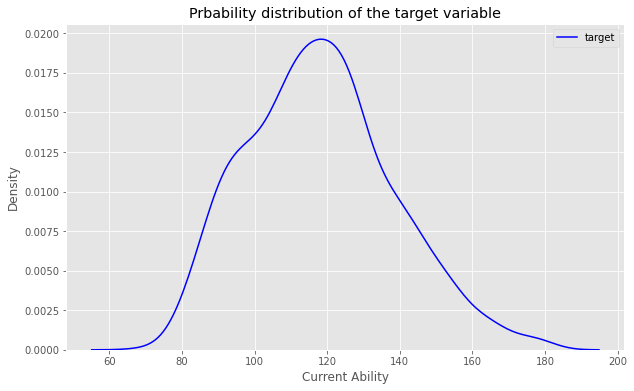

In [7]:
plt.rcParams["figure.figsize"] = (10,6)
sns.distplot(df.CA, hist = False, color = "blue", label = "target")
plt.title("Prbability distribution of the target variable")
plt.xlabel("Current Ability")
plt.legend()
plt.show()

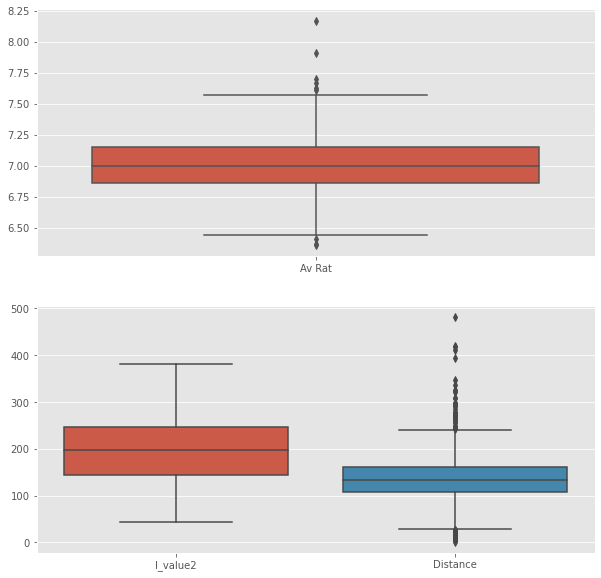

In [8]:
plt.rcParams["figure.figsize"] = (10,10)
fig,ax = plt.subplots(2, 1, squeeze=False)
sns.boxplot(data = df[["Av Rat"]], ax = ax[0,0])
sns.boxplot(data = df[["l_value2","Distance"]], ax = ax[1,0])
plt.show()

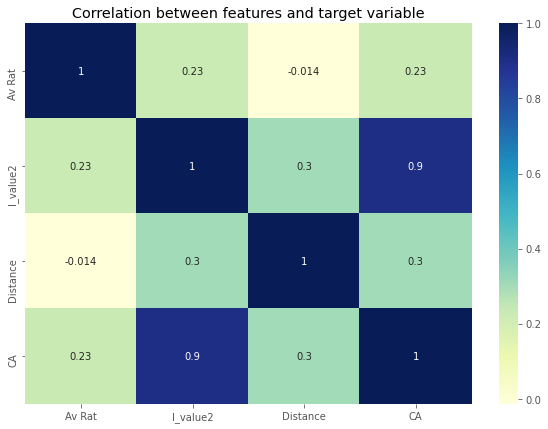

In [9]:
plt.rcParams["figure.figsize"] = (10,7)
sns.heatmap(df[['Av Rat', "l_value2","Distance","CA"]].corr(),cmap="YlGnBu",annot = True)
plt.title("Correlation between features and target variable")
plt.show()

## Model analysis

Now it is time to try to specify the best possible model. For this purpose, I carry out several tests, that is, hyperparameter tunning and residual analysis. The feature selection has been done previously, so now it is not necessary.

First of all, it is advised to split the sample into training and test sets.

In [10]:
X_train,X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 142)

The evaluation of the model performance will be centered arround two measures, that is, the Residual mean squared error or RMSE (normalized so it is between 0 and 1) and the R squared. The first one is the normalized square root of the squared mean residuals and the second one measures the variation of the target variable explained by the model (between 0 or 0% and 1 or 100%). The normalization of the first measured is obtained by dividing the RMSE by the difference of the maximum and minimum value of the target variable. Both of these measures are obtained through Cross-validation scoring (with 10 folds each).

I use a Ridge model, which is a regression model that controls the smoothness of the fit through the alpha parameter, where if the value of the parameter is high the model will fit the sample more tightly, while if it is low the fit will be smoother.   

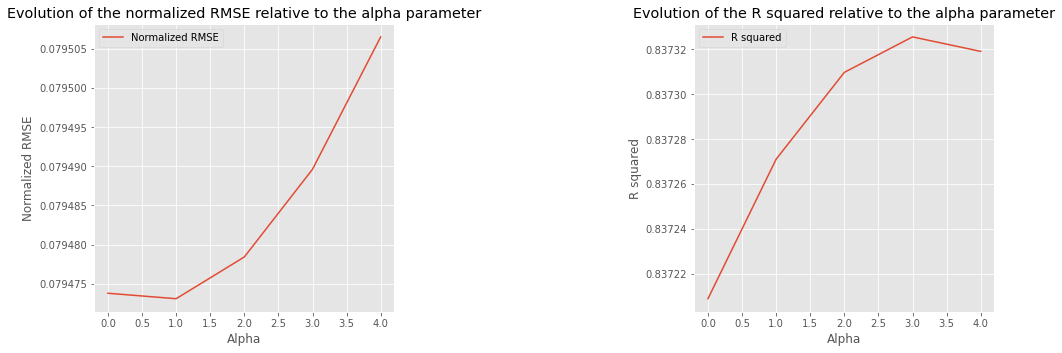

In [11]:
plt.rcParams["figure.figsize"] = (10,5)
score = []
f, (ax1, ax2) = plt.subplots(1, 2)
for i in range(0,5):
    model = Pipeline([("scale",StandardScaler()),("model",Ridge(alpha = i))])
    model.fit(X_train, y_train)
    cv_score = (cross_val_score(model, X_test, y_test, scoring = "neg_root_mean_squared_error", cv = 10)*-1)/(y_test.max().values[0]-y_test.min().values[0])
    score.append(np.mean(cv_score))
ax1.plot(range(0,5), score, label = "Normalized RMSE")
ax1.set_title("Evolution of the normalized RMSE relative to the alpha parameter")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Normalized RMSE")
ax1.legend()
score = []
for i in range(0,5):
    model = Pipeline([("scale",StandardScaler()),("model",Ridge(alpha = i))])
    model.fit(X_train, y_train)
    cv_score = cross_val_score(model, X_test, y_test, cv = 10)
    score.append(np.mean(cv_score))
ax2.plot(range(0,5), score, label = "R squared")
ax2.set_title("Evolution of the R squared relative to the alpha parameter")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("R squared")
ax2.legend()
plt.subplots_adjust(left=0,
                    bottom=0.1, 
                    right=1.25, 
                    top=0.9, 
                    wspace=1, 
                    hspace=0.4)
plt.show()

As it can be seen in the graphs, the alpha parameter that minimizes the normalized RMSE is 1, whereas the one that maximized the R squared is 3. Since the goal is to predict the Current Ability, I will chose 1 as the value for the alpha parameter. Moreover, the normalized RMSE is fairly low, and the R squared has a value of near 0.84, which would mean that almost 84% of the variation in the Current Ability is explained by the model. For these reasons, this seems to be a good specification. 

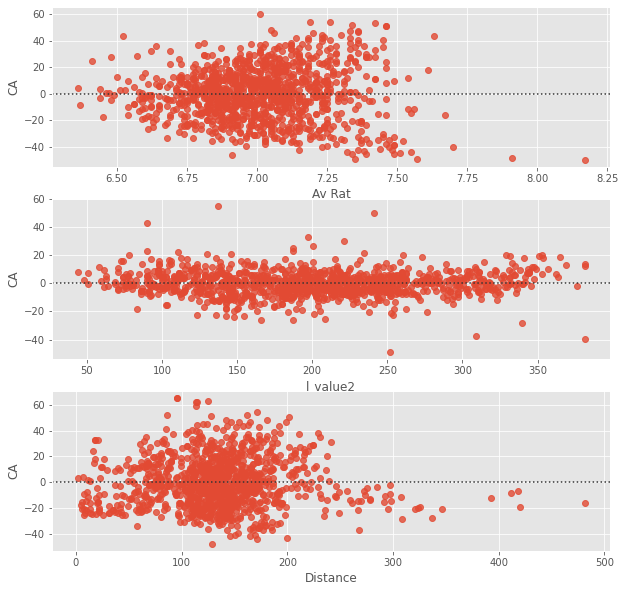

In [12]:
plt.rcParams["figure.figsize"] = (10,10)
fig,ax = plt.subplots(3, 1, squeeze=False)
sns.residplot(x = 'Av Rat', y = "CA", data = df,ax = ax[0,0])
sns.residplot(x = "l_value2", y = "CA", data = df,ax = ax[1,0])
sns.residplot(x = "Distance", y = "CA", data = df,ax = ax[2,0])
plt.show()

On the other hand, as it can be seen above, the residuals distrubite fairly even around 0, so there seems to be no need of transformation for the features.

## Model evaluation

### Performance analysis

In [13]:
model = Pipeline([("scale",StandardScaler()),("model",Ridge(alpha = 1))])
model.fit(X_train, y_train)
results = model.predict(X_test)
results_cv = cross_val_predict(model,X_test,y_test,cv=5)

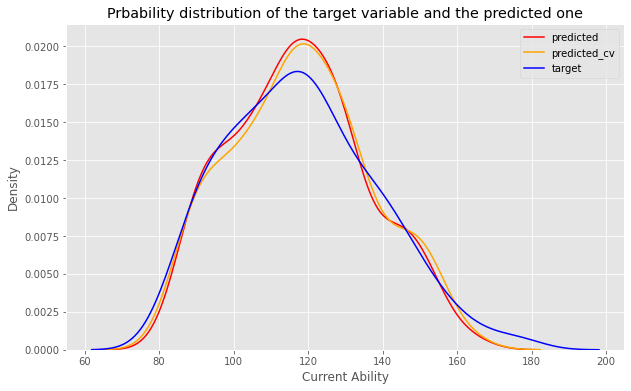

In [14]:
plt.rcParams["figure.figsize"] = (10,6)
sns.distplot(results, hist = False, color = "red", label = "predicted")
sns.distplot(results_cv, hist = False, color = "orange", label = "predicted_cv")
sns.distplot(y_test, hist = False, color = "blue", label = "target")
plt.title("Prbability distribution of the target variable and the predicted one")
plt.xlabel("Current Ability")
plt.legend()
plt.show()

As can be seen in the graph above, the model seems to be quite good at predicting the target values, as the distribution between the predicted values and the target ones does not differ in a great manner. Predicted values using the cross-validation prediction are shown for comparison. 

### Multicolinearity analysis (VIF)

The Variance Inflation Factor (VIF) measures the severity of multicollinearity in the regression model. It indicates how much does the variance of a regression coefficient increase as a result of collinearity between the variables already included in the model and the one that is being analyzed. As a general rule of thumb, values below 5 are considered to show that there are no signs of multicolinearity in the model as a result of the introduction of the variable.

In [15]:
def vif_arr(df):
	vif = pd.DataFrame()
	df = sma.add_constant(df)
	vif["variables"] = df.columns
	vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
	return(vif)

In [16]:
vif_arr(features)

,variables,VIF
0,const,1065.549527
1,Av Rat,1.063028
2,l_value2,1.170919
3,Distance,1.110553


Since none of the VIF values for the features are above 5, there seems that there are no multicolinearity problems.

## Final remarks

So, even though there may be room for improvement, it seems that this model may be a good option for predicting Current Ability. This opens up lots of possibilities, as we can derive powerful insights from the ability of the player and its value, which in turn can improve transfer movements and overall team performance.